## Testing Code

Pages saved: ['data/preprocessed/page_01.png', 'data/preprocessed/page_02.png', 'data/preprocessed/page_03.png']


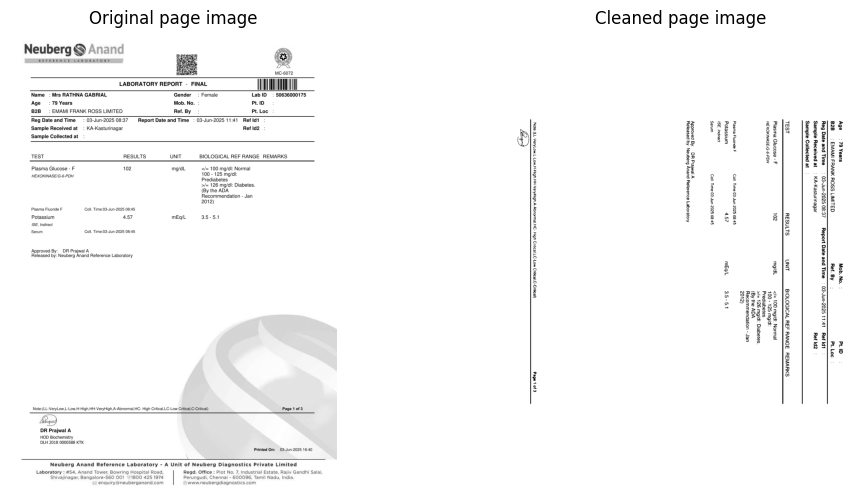

In [ ]:
# test_preprocess.py
import matplotlib.pyplot as plt
import cv2
from preprocess import pdf_to_images, deskew_and_denoise

# 1. Convert PDF to images (replace with your test file)
pdf_path = "data/82226685_Report_50636000175_RATHNA GABRIAL.pdf"
pages = pdf_to_images(pdf_path, dpi=200)
print("Pages saved:", pages)

# 2. Apply preprocessing on the first page
input_img = pages[0]
output_img = "data/preprocessed/page_01_cleaned.png"
deskew_and_denoise(input_img, output_img)

# 3. Show original vs cleaned side by side
orig = cv2.imread(input_img, cv2.IMREAD_GRAYSCALE)
clean = cv2.imread(output_img, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Original page image")
plt.imshow(orig, cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Cleaned page image")
plt.imshow(clean, cmap="gray")
plt.axis("off")

plt.show()


In [15]:
import pytesseract
import cv2
import numpy as np

def detect_orientation(image_path):
    img = cv2.imread(image_path)
    osd = pytesseract.image_to_osd(img)
    # Example OSD output: "Rotate: 270\nOrientation confidence: 20.00\n..."
    rotate_line = [l for l in osd.split("\n") if "Rotate:" in l][0]
    angle = int(rotate_line.split(":")[-1].strip())
    return angle


def auto_orient_image(image_path, out_path):
    img = cv2.imread(image_path)
    angle = detect_orientation(image_path)

    if angle != 0:
        # Rotate with OpenCV
        (h, w) = img.shape[:2]
        M = cv2.getRotationMatrix2D((w/2, h/2), -angle, 1.0)
        rotated = cv2.warpAffine(img, M, (w, h),
                                 flags=cv2.INTER_CUBIC,
                                 borderMode=cv2.BORDER_REPLICATE)
    else:
        rotated = img

    cv2.imwrite(out_path, rotated)
    return out_path

def preprocess_document(image_path, out_path):
    # Load
    img = cv2.imread(image_path)

    # --- Step 1: Tesseract OSD (coarse 0/90/180/270) ---
    osd = pytesseract.image_to_osd(img, config="--psm 0")
    angle_line = [l for l in osd.split("\n") if "Rotate:" in l][0]
    coarse_angle = int(angle_line.split(":")[-1].strip())

    if coarse_angle != 0:
        (h, w) = img.shape[:2]
        M = cv2.getRotationMatrix2D((w/2, h/2), -coarse_angle, 1.0)
        img = cv2.warpAffine(img, M, (w, h),
                             flags=cv2.INTER_CUBIC,
                             borderMode=cv2.BORDER_REPLICATE)

    # --- Step 2: Deskew (fine angle < ~5°) ---
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi/180, 200)

    fine_angle = 0.0
    if lines is not None:
        angles = []
        for rho, theta in lines[:,0]:
            ang = (theta * 180 / np.pi) - 90
            if -45 < ang < 45:
                angles.append(ang)
        if angles:
            fine_angle = np.median(angles)

    if abs(fine_angle) > 0.5:  # only correct if significant skew
        (h, w) = gray.shape[:2]
        M = cv2.getRotationMatrix2D((w/2, h/2), fine_angle, 1.0)
        img = cv2.warpAffine(img, M, (w, h),
                             flags=cv2.INTER_CUBIC,
                             borderMode=cv2.BORDER_REPLICATE)

    # --- Step 3: Denoise + threshold ---
    blur = cv2.medianBlur(img, 3)
    gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    cv2.imwrite(out_path, th)
    return out_path


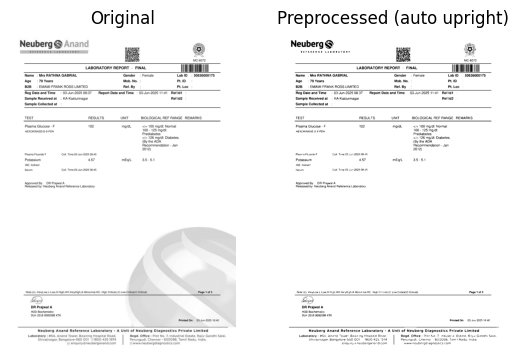

In [16]:
input_img = "data/preprocessed/page_01.png"
output_img = "data/preprocessed/page_01_final.png"

preprocess_document(input_img, output_img)

import matplotlib.pyplot as plt
orig = cv2.imread(input_img, cv2.IMREAD_GRAYSCALE)
final = cv2.imread(output_img, cv2.IMREAD_GRAYSCALE)

plt.subplot(1,2,1); plt.imshow(orig, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(final, cmap="gray"); plt.title("Preprocessed (auto upright)"); plt.axis("off")
plt.show()


In [2]:
# run_preprocess.py
from preprocess import preprocess_pdf

if __name__ == "__main__":
    pdf_path = "data/doc_2.pdf"
    out_dir = "data/preprocessed"

    processed_pages = preprocess_pdf(pdf_path, out_dir)

    print("Processed pages:")
    for p in processed_pages:
        print("preprocessed", p)


Processed pages:
preprocessed data/preprocessed/doc_2_page_01_proc.png
preprocessed data/preprocessed/doc_2_page_02_proc.png
preprocessed data/preprocessed/doc_2_page_03_proc.png
preprocessed data/preprocessed/doc_2_page_04_proc.png
preprocessed data/preprocessed/doc_2_page_05_proc.png
preprocessed data/preprocessed/doc_2_page_06_proc.png
preprocessed data/preprocessed/doc_2_page_07_proc.png
preprocessed data/preprocessed/doc_2_page_08_proc.png
preprocessed data/preprocessed/doc_2_page_09_proc.png
preprocessed data/preprocessed/doc_2_page_10_proc.png
preprocessed data/preprocessed/doc_2_page_11_proc.png


In [12]:
import os
print(os.path.exists("data/85496534_77e377bf-8723-488e-b33d-cbde2becae3c NAGASHANKAR RAO.pdf"))


True


OCR extracted 266 tokens
Sample tokens: [{'text': 'BD:', 'left': 110, 'top': 32, 'width': 222, 'height': 117, 'conf': 60.0}, {'text': 'Lat', 'left': 346, 'top': 50, 'width': 168, 'height': 79, 'conf': 56.0}, {'text': 'Pathlabe', 'left': 539, 'top': 50, 'width': 406, 'height': 81, 'conf': 60.0}, {'text': 'Name', 'left': 105, 'top': 320, 'width': 94, 'height': 26, 'conf': 96.0}, {'text': 'Lab', 'left': 105, 'top': 369, 'width': 60, 'height': 26, 'conf': 96.0}]


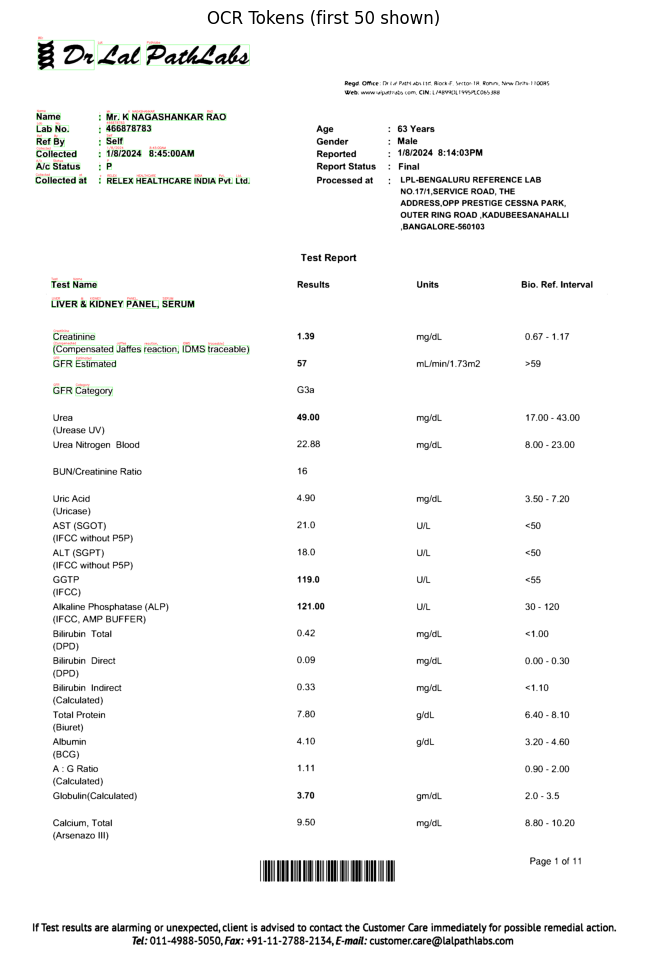

Saved 266 tokens to data/ocr_tokens/doc_2_page_01.json


In [6]:
# test_ocr.py
import cv2
import matplotlib.pyplot as plt
import json
from ocr import ocr_image_to_tokens

# Input = one of the cleaned images from Module 1
image_path = "data/preprocessed/doc_2_page_01_proc.png"
json_path = "data/ocr_tokens/doc_2_page_01.json"

tokens = ocr_image_to_tokens(image_path, out_json_path=json_path)

print(f"OCR extracted {len(tokens)} tokens")
print("Sample tokens:", tokens[:5])  # check a few

# --- Visualize tokens on image ---
img = cv2.imread(image_path)
for t in tokens[:50]:  # show only first 50 to avoid clutter
    (x, y, w, h) = (t['left'], t['top'], t['width'], t['height'])
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 1)
    cv2.putText(img, t['text'], (x, y-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,255), 1)

plt.figure(figsize=(10, 12))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("OCR Tokens (first 50 shown)")
plt.show()

# --- Check JSON output ---
with open(json_path) as f:
    saved = json.load(f)
print(f"Saved {len(saved)} tokens to {json_path}")


In [9]:
import json
import os
from rules import run_rule_extraction

ocr_dir = "data/ocr_tokens"
out_dir = "data/baseline"

os.makedirs(out_dir, exist_ok=True)

for i in range(1, 12):
    page = f"{i:02}" 
    ocr_path = os.path.join(ocr_dir, f"doc_2_page_{page}.json")
    out_path = os.path.join(out_dir, f"doc_2_page_{page}_baseline.json")

    if not os.path.exists(ocr_path):
        print(f"OCR file not found: {ocr_path}")
        continue

    with open(ocr_path, "r", encoding="utf-8") as f:
        tokens = json.load(f)

    result = run_rule_extraction(tokens)

    print(f"\n===== Page {page} =====")
    print("Extracted patient info:")
    for k, v in result.get("patient", {}).items():
        print(f"  {k}: {v}")

    print("\nExtracted tests:")
    for t in result.get("tests", []):
        print(f"  {t.get('name')} -> {t.get('value')} {t.get('unit')}")

    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(result, f, indent=2, ensure_ascii=False)

    print(f"Baseline JSON saved to: {out_path}")



===== Page 01 =====
Extracted patient info:
  office: Dr Path Biock-F. Sector. 18. Ronni, New Deitu- 10085 ta! ads ltd.
  cin: 1995PLC065 Web: idipatiiiads 17489901 com, www
  a: Ratio 0.90 2.00
  tel: 011-4988-5050, Fax: +91-11-2788-2134, E-mail: customer.care@lalpathlabs.com

Extracted tests:
  GGTP -> 119.0 U/L
Baseline JSON saved to: data/baseline/doc_2_page_01_baseline.json
OCR file not found: data/ocr_tokens/doc_2_page_02.json

===== Page 03 =====
Extracted patient info:
  office: Dr Path Biock-F. Sector. 18. Ronni, New Deitu- 10085 ta! ads ltd.
  cin: 1995PLC065 Web: idipatiiiads 17489901 com, www
  tel: 011-4988-5050, Fax: +91-11-2788-2134, E-mail: customer.care@lalpathlabs.com

Extracted tests:
  Cholesterol, Calculated -> 94.20 mg/dL
Baseline JSON saved to: data/baseline/doc_2_page_03_baseline.json
OCR file not found: data/ocr_tokens/doc_2_page_04.json
OCR file not found: data/ocr_tokens/doc_2_page_05.json
OCR file not found: data/ocr_tokens/doc_2_page_06.json
OCR file not f

In [6]:
# test_rules.py
import json
import os
from rules2 import run_rule_extraction

# Paths
ocr_path = "data/ocr_tokens/doc_1_page_01.json"
out_path = "data/baseline/doc_1_page_01_baseline.json"

if not os.path.exists(ocr_path):
    raise FileNotFoundError(f"OCR file not found: {ocr_path}")

# Load OCR JSON (from Module 2 preprocessing)
with open(ocr_path, "r") as f:
    tokens = json.load(f)

# Run rule-based extraction
result = run_rule_extraction(tokens)

# Print patient info
print("Extracted patient info:")
for k, v in result["patient"].items():
    print(f"  {k}: {v}")

# Print tests
print("\nExtracted tests:")
for t in result["tests"]:
    print(f"  {t['name']} -> {t['value']} {t['unit']}")

# Ensure baseline directory exists
os.makedirs(os.path.dirname(out_path), exist_ok=True)

# Save as baseline JSON
with open(out_path, "w") as f:
    json.dump(result, f, indent=2)

print(f"\n✅ Baseline JSON saved to: {out_path}")


Extracted patient info:
  gender: Female
  age: 79

Extracted tests:
  Plasma Glucose F -> 102 mg/dL
   -> 125 mg/dl
   -> 126 mg/dl
  Potassium -> 4.57 mEq/L

✅ Baseline JSON saved to: data/baseline/doc_1_page_01_baseline.json


## Automation

In [25]:
# run_preprocess_dynamic.py
from preprocess import preprocess_pdf

pdf_path = "data/doc_5.pdf"
out_dir = "data/preprocessed"

# This returns a list of PNG file paths, one per page
processed_pages = preprocess_pdf(pdf_path, out_dir)

print(f"Processed {len(processed_pages)} pages")
for p in processed_pages:
    print("preprocessed", p)


Processed 13 pages
preprocessed data/preprocessed/doc_5_page_01_proc.png
preprocessed data/preprocessed/doc_5_page_02_proc.png
preprocessed data/preprocessed/doc_5_page_03_proc.png
preprocessed data/preprocessed/doc_5_page_04_proc.png
preprocessed data/preprocessed/doc_5_page_05_proc.png
preprocessed data/preprocessed/doc_5_page_06_proc.png
preprocessed data/preprocessed/doc_5_page_07_proc.png
preprocessed data/preprocessed/doc_5_page_08_proc.png
preprocessed data/preprocessed/doc_5_page_09_proc.png
preprocessed data/preprocessed/doc_5_page_10_proc.png
preprocessed data/preprocessed/doc_5_page_11_proc.png
preprocessed data/preprocessed/doc_5_page_12_proc.png
preprocessed data/preprocessed/doc_5_page_13_proc.png


In [ ]:
import cv2
import matplotlib.pyplot as plt
import json
import os
from ocr import ocr_image_to_tokens

json_dir = "data/ocr_tokens"
os.makedirs(json_dir, exist_ok=True)

for img_path in processed_pages:  # comes from Cell 1
    base = os.path.splitext(os.path.basename(img_path))[0] 
    json_path = os.path.join(json_dir, base.replace("_proc", "") + ".json")

    tokens = ocr_image_to_tokens(img_path, out_json_path=json_path)

    print(f"\n===== {base} =====")
    print(f"OCR extracted {len(tokens)} tokens")
    print("Sample tokens:", tokens[:5])

    # Visualize (optional: only first 50 tokens)
    img = cv2.imread(img_path)
    for t in tokens[:50]:
        (x, y, w, h) = (t['left'], t['top'], t['width'], t['height'])
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 1)
        cv2.putText(img, t['text'], (x, y-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,255), 1)

    plt.figure(figsize=(10, 12))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"OCR Tokens – {base} (first 50 shown)")
    plt.show()

    with open(json_path, "r", encoding="utf-8") as f:
        saved = json.load(f)
    print(f"Saved {len(saved)} tokens to {json_path}")


In [27]:
import json
import os
from rules import run_rule_extraction

ocr_dir = "data/ocr_tokens"
out_dir = "data/baseline"

os.makedirs(out_dir, exist_ok=True)

for i in range(1, 12):
    page = f"{i:02}" 
    ocr_path = os.path.join(ocr_dir, f"doc_5_page_{page}.json")
    out_path = os.path.join(out_dir, f"doc_5_page_{page}_baseline.json")

    if not os.path.exists(ocr_path):
        print(f"OCR file not found: {ocr_path}")
        continue

    with open(ocr_path, "r", encoding="utf-8") as f:
        tokens = json.load(f)

    result = run_rule_extraction(tokens)

    print(f"\n===== Page {page} =====")
    print("Extracted patient info:")
    for k, v in result.get("patient", {}).items():
        print(f"  {k}: {v}")

    print("\nExtracted tests:")
    for t in result.get("tests", []):
        print(f"  {t.get('name')} -> {t.get('value')} {t.get('unit')}")

    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(result, f, indent=2, ensure_ascii=False)

    print(f"Baseline JSON saved to: {out_path}")



===== Page 01 =====
Extracted patient info:
  gender: Name Mr K P Male LabID 50641000301
  cc: >
  160: High
  note:(llverylow,llow,hhigh,hhveryhigh.aabnormal.hc: Critical,LC-Low Critical,C-Critical) High Page 1 of 13
  on: Printed 29-Jun-2025 12:23

Extracted tests:
  Calcium Adjusted -> 8.1 mg/dL
  Cholesterol Optimal LDL (Direct) -> 32 mg/dL
Baseline JSON saved to: data/baseline/doc_5_page_01_baseline.json

===== Page 02 =====
Extracted patient info:
  age: 40 Years Mob. No. 9035707662 Pt.ID 6186848
  time:29jun2025: 06:42
  by: Neuberg Anand Reference Laboratory
  note:(llverylow,llow,hhigh,hhveryhigh.aabnormal.hc: Critical,LC-Low Critical,C-Critical) High Page 2 of 13
  on: Printed 29-Jun-2025 12:23

Extracted tests:
Baseline JSON saved to: data/baseline/doc_5_page_02_baseline.json

===== Page 03 =====
Extracted patient info:
  gender: Name Mr K P Male LabID 50641000301
  age: 40 Years Mob. No. 9035707662 Pt.ID 6186848
  note:(llverylow,llow,hhigh,hhveryhigh.aabnormal.hc: Critica

In [40]:
import json

ocr_file = "data/ocr_tokens/doc_5_page_13.json"


corrected_structured = {
"patient": {
"name": {
"Value": "Mr K P SHRAVAN"
},
"age": {
"Value": "40 Years"
},
"gender": {
"Value": "Male"
},
"lab_id": {
"Value": "50641000301"
},
"mob_no": {
"Value": "9035707662"
},
"reg_date_and_time": {
"Value": "29-Jun-2025 06:37"
},
"report_date_and_time": {
"Value": "29-Jun-2025 12:22"
},
"sample_received_at": {
"Value": "KA-Bannergatta Road"
},
"ref_by": {
"Value": "VIKRAM KAMATH"
}
},
"tests": [
{
"name": "Active - B12 ( Holotrascobalamine)"
},
{
"name": "Active - B12",
"value": "> 256.0",
"unit": "pmol/L",
"reference_range": "25.1 - 165.0",
"method": "CMIA",
"sample_type": "Serum",
"collection_time": "29-Jun-2025 06:42"
}
],
"additional_sections": {
"approval_and_release": [
{
"approved_by": "DR Prajwal A"
},
{
"released_by": "Neuberg Anand Reference Laboratory"
}
],
"signature": [
{
"name": "DR Prajwal A",
"role": "Consultant Biochemist",
"credentials": "DLH 2018 0000588 KTK"
}
],
"printed_on": [
{
"value": "29-Jun-2025 12:23"
}
]
}
}


with open(ocr_file, "r", encoding="utf-8") as f:
    original_tokens = json.load(f)


merged = {
    "original_tokens": original_tokens,
    "corrected_structured": corrected_structured
}


output_file = "data/corrections/doc_5_page_13_correction.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(merged, f, indent=2, ensure_ascii=False)

print(f"Merged JSON saved to {output_file}")


Merged JSON saved to data/corrections/doc_5_page_13_correction.json
